In [1]:
import pickle

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, f1_score, log_loss, precision_score, recall_score
from sklearn.model_selection import train_test_split

import modelmetrics

# In this chapter, we're using Logistic Regression 
It works by modeling the probability of a sentiment label positive,negative or neutra.
Overall,logistic regression is a simple yet effective algorithm for sentiment analysis that can be applied to a wide range of datasets and text data.

In [2]:
data = pd.read_csv('Data/dacy_sentiment.csv', lineterminator='\n')
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
data['sentiment'] = data['sentiment'].replace(sentiment_map)
data

,company,title,body,rating,sentiment,predicted,prob_pos,prob_neu,prob_neg\r
0,UPS,forkert adresse måtte selv hente den det rigti...,"Jeg bestilte nogle Nike sko, hvorefter der sto...",1,-1,neutral,0.011,0.986,0.003
1,UPS,Værste amatør nogensinde,Værste amatør nogensinde. Allerede flere gange...,1,-1,negative,0.002,0.001,0.998
2,UPS,Virkelig tynd kundeservice,Virkelig tynd kundeservice. Kan ikke sende et ...,1,-1,negative,0.022,0.001,0.978
3,PostNord i Danmark,Præcision og hurtig levering,Præcision og hurtig levering,5,1,positive,0.914,0.081,0.004
4,UPS,"😡 UPS, aldrig igen!",Hold da op!Hvad sker der for UPS? Kundeservice...,1,-1,positive,0.798,0.110,0.092
...,...,...,...,...,...,...,...,...,...
595,PostNord i Danmark,God information og hurtig levering,God information og hurtig levering,5,1,positive,0.977,0.023,0.001
596,PostNord i Danmark,Som altid perfekt kh louise,Som altid perfekt kh louise,5,1,positive,0.999,0.000,0.001
597,UPS,frem og tilbage uden problemer,Jamen....der er ikke så meget at sige end...BR...,5,1,positive,0.963,0.022,0.015
598,UPS,Pakkemanden vil hellere udfylde en …,Pakkemanden vil hellere udfylde en seddel end ...,1,-1,neutral,0.017,0.921,0.062


## Training and testing the model

In this process, we are training a logistic regression classifier on a dataset of customer reviews to predict the sentiment of new, previously unseen reviews.

First, we split the dataset into a training set and a test set using the sample() and drop() methods from pandas. Then, we create a CountVectorizer object to convert the text data into a bag-of-words representation, which counts the occurrence of each word in the text. We fit the vectorizer on the training set and use it to transform both the training and test sets into vectors of word counts.

Next, we train the LogisticRegression classifier on the training vectors and corresponding sentiment labels. We use the trained classifier to predict the sentiment of a new, previously unseen review by converting it into a vector using the same vectorizer, and then calling predict() on the classifier object.

Finally, we print the predicted sentiment, as well as the actual review (if it was predicted to be negative) and the counts of each sentiment label in the dataset.

Overall, this process demonstrates a basic workflow for sentiment analysis using a logistic regression classifier and bag-of-words representations.

In [3]:
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features=1000)
train_vectors = vectorizer.fit_transform(train_data['body'])
test_vectors = vectorizer.transform(test_data['body'])

clf = LogisticRegression(random_state=42)
clf.fit(train_vectors, train_data['sentiment'])

#new_review = data.loc[1, 'body']
new_review = "Bedste levering, super godt arbejde af postnord, lige til tiden"
new_review_vector = vectorizer.transform([new_review])
predicted_sentiment = clf.predict(new_review_vector)[0]

#Tjekker hvor mange af hver der
sentiment_counts = data['sentiment'].value_counts()
print(sentiment_counts)

if predicted_sentiment == 1:
    print("Positive sentiment")
elif predicted_sentiment == 0:
    print("Neutral sentiment")
else:
    print("Negative sentiment")
    #print("Actual: ", data.loc[1,'body'])

 1    332
-1    250
 0     18
Name: sentiment, dtype: int64
Positive sentiment


In [4]:
y_true = test_data['sentiment']
y_pred = clf.predict(test_vectors)
probs = clf.predict_proba(test_vectors)

report = classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
print(report)

              precision    recall  f1-score   support

    Negative       0.94      0.92      0.93        52
     Neutral       0.00      0.00      0.00         4
    Positive       0.90      0.95      0.92        64

    accuracy                           0.91       120
   macro avg       0.61      0.63      0.62       120
weighted avg       0.89      0.91      0.90       120



In [5]:
log_loss_test = log_loss(y_true, probs)
log_loss_test

0.32219955297612185

In [ ]:
print('Accuracy:', accuracy_score(y_true, y_pred))
print('Precision:', precision_score(y_true, y_pred))
print('Recall:', recall_score(y_true, y_pred))
print('F1 Score:', f1_score(y_true, y_pred))

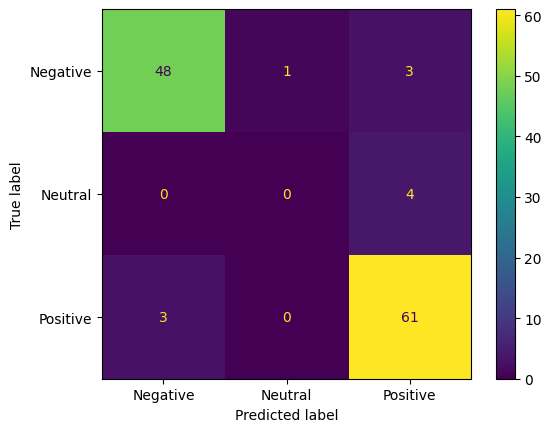

In [7]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=['Negative', 'Neutral', 'Positive'])

Save the performance metrics to a file.

In [8]:
report = classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive'], output_dict=True)
report['log_loss'] = log_loss_test
modelmetrics.save_to_file('Data/metrics.csv', 'LogisticRegression', report)

Also save the models so we can use them again later if needed.

In [9]:
with open('Models/logreg_count_vec.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
with open('Models/logreg_model.pkl', 'wb') as f:
    pickle.dump(clf, f)